In [1]:
import pandas as pd, numpy as np
import math, datetime, sklearn
from datetime import date

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, pairwise_distances
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, PredefinedSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [2]:
directory = "zillow-prize-1/"

train_2016 = pd.read_csv(directory+"train_2016_v2.csv", parse_dates=["transactiondate"])
properties_2016 = pd.read_csv(directory+"properties_2016.csv")
df_2016 = train_2016.merge(properties_2016)

train_2017 = pd.read_csv(directory+"train_2017.csv", parse_dates=["transactiondate"])
properties_2017 = pd.read_csv(directory+"properties_2017.csv")
df_2017 = train_2017.merge(properties_2017)

df = pd.concat([df_2016, df_2017], join = "inner", ignore_index=True)
df

C:\Users\david\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\david\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.168400,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.004000,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.021800,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.005000,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13


In [3]:
df.logerror.isna().any()

False

In [4]:
#mi interessano sono le transazioni quindi elimino tutte le case non vendute (non ce ne dovrebbero essere ma lo faccio comunque per sicurezza)
df.dropna(subset=['logerror'], inplace = True)

#trasformo le date in interi che rappresentano la distanza in giorni dal 2016/01/01
df.loc[:, 'transactiondate'] = (df['transactiondate'].dt.date-date(2016, 1, 1)).dt.days

#ordino il df per data (mi serve per molte cose, a partire dal train)
df.sort_values(by = "transactiondate", ignore_index = True, inplace=True)

df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,0,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,0,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [46]:
TRAIN_RATIO = 0.6
TEST_RATIO = 0.15
NAN_TOLLERANCE = 0.6
ENCODED_SET = set()
REPLACED_NANS_SET = set()
OTHER_COL_VALUE = "otherColsVal"


def train_len(data = None):
    if data is None:
        data = df
    return math.floor(TRAIN_RATIO*len(data))

def test_len(data = None):
    if data is None:
        data = df
    return math.floor(TEST_RATIO*len(data))

def train_validation_len(data = None):
    if data is None:
        data = df
    return len(data) - test_len(data)

def validation_len(data = None):
    if data is None:
        data = df
    return train_validation_len(data) - train_len(data)
    

def train(data = None):
    if data is None:
        data = df
    if isinstance(data, np.ndarray):
        return data[:train_len(data)].copy()
    return data.iloc[:train_len(data)].copy()

def test(data = None):
    if data is None:
        data = df
    if isinstance(data, np.ndarray):
        return data[-test_len(data):].copy()
    return data.iloc[-test_len(data):].copy()

def train_validation(data = None):
    if data is None:
        data = df
    if isinstance(data, np.ndarray):
        return data[:train_validation_len(data)].copy()
    return data.iloc[:train_validation_len(data)].copy()

def validation(data = None):
    if data is None:
        data = df
    if isinstance(data, np.ndarray):
        return data[train_len(data) : train_validation_len(data)].copy()
    return data.iloc[train_len(data) : train_validation_len(data)].copy()


def predictor(data = None):
    if data is None:
        data = df
    if isinstance(data, np.ndarray):
        return data[:, 1:].copy()
    return data.drop(columns = 'logerror')

def target(data = None):
    if data is None:
        data = df
    if isinstance(data, np.ndarray):
        return data[:, 0].copy()
    return data['logerror'].copy()


def drop_sparse_features(data = None):
    if data is None:
        data = df
    return data.drop(columns = data.columns[train(data).isna().mean() + train(data).eq(OTHER_COL_VALUE).mean() > NAN_TOLLERANCE])

def drop_constants(data = None):
    if data is None:
        data = df
    return data.drop(columns = data.columns[train(data).nunique() < 2])


def set_binary_cols(data = None):
    if data is None:
        data = df
    return {col for col in data.columns[train(data).nunique(dropna = False) <= 2] if "has" in col or "flag" in col or "pooltypeid" in col}

def set_nominal_cols(data = None):
    if data is None:
        data = df
    def set_object_cols():
        return {col for col in data.columns if data[col].dtype == object}
    def set_id_cols():
        return {col for col in data.columns if 'id' in col}
    return ((set_object_cols() | set_id_cols() | {'fips', 'censustractandblock', 'rawcensustractandblock'} | ENCODED_SET) - set_binary_cols(data)) & set(data.columns)

def set_numerical_cols(data = None):
    if data is None:
        data = df
    return set(data.columns) - set_nominal_cols(data) - set_binary_cols(data) - {'logerror'} - REPLACED_NANS_SET

def set_size_cols(data = None):
    if data is None:
        data = df
    return {col for col in data.columns if 'cnt' in col or 'feet' in col or 'sqft' in col or 'size' in col}

def set_ordinal_cols(data = None):
    if data is None:
        data = df
    return {col for col in set_numerical_cols(data) if not ('cnt' in col or 'feet' in col or 'sqft' in col) and np.array_equal(data[col].dropna(), data[col].dropna().astype(int))}

def set_continuous_cols(data = None):
    if data is None:
        data = df
    return set_numerical_cols() - set_ordinal_cols()


def binary_cols(data = None):
    if data is None:
        data = df
    return [col for col in data.columns if col in set_binary_cols(data)]

def nominal_cols(data = None):
    if data is None:
        data = df
    return [col for col in data.columns if col in set_nominal_cols(data)]

def numerical_cols(data = None):
    if data is None:
        data = df
    return [col for col in data.columns if col in set_numerical_cols(data)]

def size_cols(data = None):
    if data is None:
        data = df
    return [col for col in data.columns if col in set_size_cols(data)]

def ordinal_cols(data = None):
    if data is None:
        data = df
    return [col for col in data.columns if col in set_ordinal_cols(data)]

def continuous_cols(data = None):
    if data is None:
        data = df
    return [col for col in data.columns if col in set_continuous_cols(data)]


def preprocess_binary_features(data = None):
    if data is None:
        data = df.copy()
    binc = binary_cols(data)
    data[binc] = data[binc].fillna(0)
    data[binc] = data[binc].applymap(lambda x: False if x==0 else True)
    data[binc] = data[binc].astype(int)
    return data

def preprocess_size_features(data = None):
    if data is None:
        data = df.copy()
    tr = train(data)
    sizc = [col for col in size_cols(data) if not (0 in tr[col])]
    data[sizc] = data[sizc].fillna(0.0)
    return data

def preprocess_numerical_features(data = None):
    if data is None:
        data = df.copy()
    tr = train(data)
    ordc = ordinal_cols(data)
    contc = continuous_cols(data)
    
    nans = data[numerical_cols(data)].isna().astype(int)
    nans = drop_constants(nans)
    nans = nans.add_prefix("isnan_")
    global REPLACED_NANS
    REPLACED_NANS = set(nans.columns)
    
    data[ordc] = data[ordc].fillna(tr[ordc].median())
    data[ordc] = data[ordc].astype(int)
    data[contc] = data[contc].fillna(tr[contc].mean())
    
    return pd.concat([data, nans], axis=1)

def one_hot_encode(data = None, max_cols = 5, tol = NAN_TOLLERANCE):
    if data is None:
        data = df.copy()
    tr = train(data)
    nomc = nominal_cols(data)
    
    for col in nomc:
        most_frequent_values = tr[col].value_counts().index[:max_cols].tolist()
        data[col] = data[col].apply(lambda x: x if x in most_frequent_values else OTHER_COL_VALUE).astype(str)
    data = drop_sparse_features(data)
    
    nomc = nominal_cols(data)
    tr = train(data)
    
    oh = OneHotEncoder(sparse=False)
    oh.fit(tr[nomc])
    encoded = oh.transform(data[nomc])
    
    data = data.drop(columns = nomc)
    global ENCODED_SET
    ENCODED_SET = oh.get_feature_names_out()
    data[oh.get_feature_names_out()] = encoded
    
    return data


def model_RFECV(model, data = None, min_features = 2, n_est = 100, leaves=64, d=1):
    if data is None:
        if model == 'RandomForestRegressor':
            data = df_rf.copy()
        elif model == "Boosting":
            data = df_boost.copy()
        elif model == "LinearRegression":
            data = df_lr[d].copy()
        else:
            raise valueError("wrong model")
    
    trval_X = train_validation(predictor(data))
    trval_y = train_validation(target(data))
    X = np.array(trval_X)
    y = np.array(trval_y).squeeze()

    n1 = train_len(data)
    n2 = len(trval_X)-n1
    
    split_index = [-1]*n1 + [0]*n2
    pds = PredefinedSplit(test_fold = split_index)
    
    if model == 'RandomForestRegressor':
        mod_small = RandomForestRegressor(n_estimators=n_est, n_jobs=-1)
    elif model == 'Boosting':
        dt = DecisionTreeRegressor(max_leaf_nodes=leaves)
        mod_small = AdaBoostRegressor(base_estimator=dt, n_estimators=n_est)
    elif model == 'LinearRegression':
        mod_small = LinearRegression(fit_intercept=True)
    else:
        raise valueError("wrong model")
    selector = RFECV(mod_small, 
                     step=1, # features removed at each step
                     cv=pds,
                     scoring='neg_mean_squared_error', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                     min_features_to_select=min_features, # selected features
                     n_jobs=-1
                    )
    selector.fit(X,y)
    return selector

def model_tuning(model = None, data = None, parameters = {'n_estimators': [n for n in range(100, 1001, 100)]}):
    if data is None:
        if model == 'RandomForestRegressor':
            data = df_rf.copy()
        elif model == "Boosting":
            data = df_boost.copy()
        elif model == "LinearRegression":
            data = df_lr[d].copy()
        else:
            raise valueError("wrong model")
    
    trval_X = train_validation(predictor(data))
    trval_y = train_validation(target(data))
    X = np.array(trval_X)
    y = np.array(trval_y).squeeze()
    
    n1 = train_len(data)
    n2 = validation_len(data)
    
    split_index = [-1]*n1 + [0]*n2
    pds = PredefinedSplit(test_fold = split_index)
    
    if model == 'RandomForestRegressor':
        mod = RandomForestRegressor(n_jobs=-1)
    elif model == 'Boosting':
        dt = DecisionTreeRegressor()
        mod = AdaBoostRegressor(base_estimator=dt)
    
    tuned_model = HalvingGridSearchCV(mod,
                               parameters,
                               cv=pds,
                               verbose=0,
                               n_jobs=-1)
    tuned_model.fit(X, y)
    return tuned_model

def train_model(model = None, data = None, n_est = 100, leaves=64, d=1):
    if data is None:
        if model == 'RandomForestRegressor':
            data = df_rf.copy()
        elif model == "Boosting":
            data = df_boost.copy()
        elif model == "LinearRegression":
            data = df_lr[d].copy()
        else:
            raise valueError("wrong model")
    
    tr_X = np.array(train(predictor(data)))
    tr_y = np.array(train(target(data))).squeeze()
    
    if model == 'RandomForestRegressor':
        mod = RandomForestRegressor(n_estimators=n_est, n_jobs=-1)
    elif model == "Boosting":
        dt = DecisionTreeRegressor(max_leaf_nodes=leaves)
        mod = AdaBoostRegressor(base_estimator=dt, n_estimators=n_est)
    elif model == "LinearRegression":
        mod = LinearRegression(fit_intercept=True)
    else:
        raise valueError("wrong model")
    
    mod.fit(tr_X, tr_y)
    return mod

def model_y(on, model = None, data = None, n_est = 100, leaves=64, d=1):  
    if data is None:
        if model == 'RandomForestRegressor':
            data = df_rf.copy()
        elif model == "Boosting":
            data = df_boost.copy()
        elif model == "LinearRegression":
            data = df_lr[d].copy()
        else:
            raise valueError("wrong model")
    
    if on == "test":
        X = np.array(test(predictor(data)))
        y = np.array(test(target(data))).squeeze()
    elif on == "validation":
        X = np.array(validation(predictor(data)))
        y = np.array(validation(target(data))).squeeze()
    elif on == "all":
        X = np.array(predictor(data))
        y = np.array(target(data)).squeeze()
    elif on == "train":
        X = np.array(train(predictor(data)))
        y = np.array(train(target(data))).squeeze()
    else:
        raise valueError("wrong on parameter")
    
    mod = train_model(model = model, data = data, n_est = n_est, leaves = leaves, d=d)
    y_pred = mod.predict(X)
    return y, y_pred

def model_mse(model = None, data = None, n_est = 100, leaves=64, d=1, on = "test"):    
    y_true, y_pred = model_y(on = on, model = model, data = data, n_est = n_est, leaves = leaves, d=d)
    return mean_squared_error(y_true = y_true, y_pred = y_pred)

def model_plot(model = None, data = None, n_est = 100, leaves=64, d=1):
    if data is None:
        if model == 'RandomForestRegressor':
            data = df_rf.copy()
        elif model == "Boosting":
            data = df_boost.copy()
        elif model == "LinearRegression":
            data = df_lr[d].copy()
        else:
            raise valueError("wrong model")
    X = np.array(predictor(data))
    y = np.array(target(data)).squeeze()
    y_true, y_pred = model_y(on = "all", model = model, data = data, n_est = n_est, leaves = leaves, d=d)
    
    fig, ax = plt.subplots()
    ax.plot(train(y_true), train(y_pred), 'o:', label='train')
    ax.plot(validation(y_true), validation(y_pred), '*', label='validation')
    ax.plot(test(y_true), test(y_pred), 's:', label='test')
    ax.set_title(model)
    ax.set_ylabel("Predicted Value")
    ax.set_xlabel("True Value");
    ax.legend();

def rf_feature_importance(data = None, n_est = 1000):
    if data is None:
        data = df.copy()
    X = np.array(predictor(data))
    rf = train_model(model = "RandomForestRegressor", data = data, n_est = n_est)
    fig, ax = plt.subplots()
    ax.bar(range(0,X.shape[1]), rf.feature_importances_)
    ax.set_title("Feature Importances")
    ax.set_xticks(range(X.shape[1]))
    ax.set_xticklabels(predictor(data).columns)
    ax.grid();

def random_forest_similarity(data = None, n_est = 1000):
    rf = train_model(model = "RandomForestRegressor", data = data, n_est = n_est)
    leaves = rf.apply(np.array(train(predictor(data))))
    return pairwise_distances( X=leaves, metric = lambda oi, oj: np.mean(oi==oj))
    
def random_forest_outliers(data = None, n_est = 1000):
    if data is None:
        data = df.copy()
    pair_wise_sim = random_forest_similarity(data = data, n_est = n_est)
    return (pair_wise_sim**2).sum(axis=0)**-1

def feature_boxplot(data = None, feature = 'logerror'):
    if data is None:
        data = df.copy()
    fig, ax = plt.subplots()
    ax.boxplot(data[feature])
    ax.set_title("boxplot " + feature)

In [6]:
#creo una nuova colonna che indica quante volte è già stata venduta una casa
df["countalreadysold"] = df.groupby('parcelid').cumcount()

#a questo punto posso eliminare parcelid che non mi serve più (nota: in un dataset reale lo terrei comunque da parte per countalreadysold)
df.drop(columns = "parcelid", inplace = True)

df.head()

,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,countalreadysold
0,0.0276,0,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13,0
1,-0.1684,0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN,0
2,-0.0040,0,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13,0
3,0.0218,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13,0
4,-0.0050,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13,0


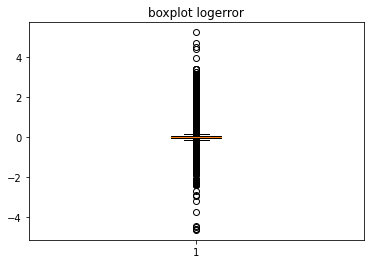

In [7]:
feature_boxplot()

In [8]:
for col in df.columns[train().nunique(dropna = False) <= 2]:
    print(col, " ", train()[col].unique())
print({col for col in df.columns if "pool" in col})
print(0 in (train().poolsizesum.unique().tolist()))

print()
print({col : 0 in df[col].unique().tolist() for col in set_size_cols()})

buildingclasstypeid   [nan  4.]
decktypeid   [nan 66.]
hashottuborspa   [nan True]
poolcnt   [nan  1.]
pooltypeid10   [nan  1.]
pooltypeid2   [nan  1.]
pooltypeid7   [nan  1.]
storytypeid   [nan  7.]
fireplaceflag   [nan True]
taxdelinquencyflag   [nan 'Y']
{'pooltypeid7', 'poolcnt', 'pooltypeid2', 'poolsizesum', 'pooltypeid10'}
False

{'bathroomcnt': True, 'garagecarcnt': True, 'poolcnt': False, 'yardbuildingsqft26': False, 'structuretaxvaluedollarcnt': False, 'roomcnt': True, 'finishedsquarefeet6': False, 'finishedsquarefeet15': False, 'fullbathcnt': False, 'unitcnt': False, 'finishedfloor1squarefeet': False, 'fireplacecnt': False, 'calculatedfinishedsquarefeet': False, 'lotsizesquarefeet': False, 'landtaxvaluedollarcnt': False, 'basementsqft': False, 'yardbuildingsqft17': False, 'taxvaluedollarcnt': False, 'finishedsquarefeet13': False, 'finishedsquarefeet12': False, 'poolsizesum': False, 'garagetotalsqft': True, 'finishedsquarefeet50': False, 'bedroomcnt': True}


In [9]:
print(binary_cols())
print(set_size_cols())

['hashottuborspa', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'fireplaceflag', 'taxdelinquencyflag']
{'bathroomcnt', 'garagecarcnt', 'poolcnt', 'yardbuildingsqft26', 'structuretaxvaluedollarcnt', 'roomcnt', 'finishedsquarefeet6', 'finishedsquarefeet15', 'fullbathcnt', 'unitcnt', 'finishedfloor1squarefeet', 'fireplacecnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'landtaxvaluedollarcnt', 'basementsqft', 'yardbuildingsqft17', 'taxvaluedollarcnt', 'finishedsquarefeet13', 'finishedsquarefeet12', 'poolsizesum', 'garagetotalsqft', 'finishedsquarefeet50', 'bedroomcnt'}


In [10]:
df = preprocess_binary_features()
df.head()

,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,countalreadysold
0,0.0276,0,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,0,122754.0,360170.0,2015.0,237416.0,6735.88,0,NaN,6.037107e+13,0
1,-0.1684,0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,0,346458.0,585529.0,2015.0,239071.0,10153.02,0,NaN,NaN,0
2,-0.0040,0,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,0,61994.0,119906.0,2015.0,57912.0,11484.48,0,NaN,6.037464e+13,0
3,0.0218,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,0,171518.0,244880.0,2015.0,73362.0,3048.74,0,NaN,6.037296e+13,0
4,-0.0050,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,0,169574.0,434551.0,2015.0,264977.0,5488.96,0,NaN,6.059042e+13,0


In [11]:
df = preprocess_size_features()
df.head()

,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,countalreadysold
0,0.0276,0,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,0,122754.0,360170.0,2015.0,237416.0,6735.88,0,NaN,6.037107e+13,0
1,-0.1684,0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,0,346458.0,585529.0,2015.0,239071.0,10153.02,0,NaN,NaN,0
2,-0.0040,0,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,0,61994.0,119906.0,2015.0,57912.0,11484.48,0,NaN,6.037464e+13,0
3,0.0218,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,0,171518.0,244880.0,2015.0,73362.0,3048.74,0,NaN,6.037296e+13,0
4,-0.0050,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,0,169574.0,434551.0,2015.0,264977.0,5488.96,0,NaN,6.059042e+13,0


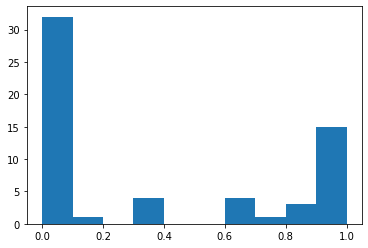

logerror                        0.000000
taxdelinquencyflag              0.000000
fireplaceflag                   0.000000
pooltypeid7                     0.000000
pooltypeid2                     0.000000
pooltypeid10                    0.000000
hashottuborspa                  0.000000
countalreadysold                0.000000
transactiondate                 0.000000
propertylandusetypeid           0.000089
rawcensustractandblock          0.000089
bathroomcnt                     0.000089
regionidcounty                  0.000089
longitude                       0.000089
latitude                        0.000089
assessmentyear                  0.000089
bedroomcnt                      0.000089
roomcnt                         0.000089
fips                            0.000089
propertycountylandusecode       0.000099
taxvaluedollarcnt               0.000099
landtaxvaluedollarcnt           0.000099
taxamount                       0.000159
regionidzip                     0.000526
structuretaxvalu

In [12]:
plt.hist(train().isna().mean(), range = (0, 1))
plt.show()
train().isna().mean().sort_values()

In [13]:
#elimino trovo le features con più missing values nel train
df = drop_sparse_features()
df.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,yearbuilt,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,countalreadysold
0,0.0276,0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,...,1959.0,0,122754.0,360170.0,2015.0,237416.0,6735.88,0,6.037107e+13,0
1,-0.1684,0,3.5,4.0,NaN,3.5,2263.0,2263.0,6059.0,3.0,...,2014.0,0,346458.0,585529.0,2015.0,239071.0,10153.02,0,NaN,0
2,-0.0040,0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,...,1940.0,0,61994.0,119906.0,2015.0,57912.0,11484.48,0,6.037464e+13,0
3,0.0218,1,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,...,1987.0,0,171518.0,244880.0,2015.0,73362.0,3048.74,0,6.037296e+13,0
4,-0.0050,1,2.5,4.0,NaN,2.5,2283.0,2283.0,6059.0,2.0,...,1981.0,0,169574.0,434551.0,2015.0,264977.0,5488.96,0,6.059042e+13,0


In [14]:
print(set_nominal_cols())
print(set_numerical_cols())

{'censustractandblock', 'regionidzip', 'fips', 'regionidcounty', 'buildingqualitytypeid', 'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity', 'propertylandusetypeid', 'heatingorsystemtypeid', 'propertyzoningdesc'}
{'taxamount', 'bathroomcnt', 'landtaxvaluedollarcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'assessmentyear', 'transactiondate', 'roomcnt', 'latitude', 'countalreadysold', 'fullbathcnt', 'unitcnt', 'longitude', 'taxvaluedollarcnt', 'finishedsquarefeet12', 'calculatedfinishedsquarefeet', 'calculatedbathnbr', 'lotsizesquarefeet', 'bedroomcnt'}


In [15]:
print(set_ordinal_cols())
print(ordinal_cols())
df[set_ordinal_cols()].head()

{'countalreadysold', 'longitude', 'yearbuilt', 'assessmentyear', 'transactiondate', 'latitude'}
['transactiondate', 'latitude', 'longitude', 'yearbuilt', 'assessmentyear', 'countalreadysold']


,countalreadysold,longitude,yearbuilt,assessmentyear,transactiondate,latitude
0,0,-118488536.0,1959.0,2015.0,0,34280990.0
1,0,-117677556.0,2014.0,2015.0,0,33668120.0
2,0,-118175032.0,1940.0,2015.0,0,34136312.0
3,0,-118309000.0,1987.0,2015.0,1,33755800.0
4,0,-117700234.0,1981.0,2015.0,1,33485643.0


In [16]:
df = preprocess_numerical_features()
df.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,isnan_longitude,isnan_lotsizesquarefeet,isnan_roomcnt,isnan_unitcnt,isnan_yearbuilt,isnan_structuretaxvaluedollarcnt,isnan_taxvaluedollarcnt,isnan_assessmentyear,isnan_landtaxvaluedollarcnt,isnan_taxamount
0,0.0276,0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.1684,0,3.5,4.0,NaN,3.5,2263.0,2263.0,6059.0,3.0,...,0,0,0,1,0,0,0,0,0,0
2,-0.0040,0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0218,1,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,-0.0050,1,2.5,4.0,NaN,2.5,2283.0,2283.0,6059.0,2.0,...,0,0,0,1,0,0,0,0,0,0


In [17]:
df = one_hot_encode()
df.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,hashottuborspa,latitude,...,propertylandusetypeid_246.0,propertylandusetypeid_248.0,propertylandusetypeid_261.0,propertylandusetypeid_266.0,propertylandusetypeid_269.0,propertylandusetypeid_otherColsVal,regionidcounty_1286.0,regionidcounty_2061.0,regionidcounty_3101.0,regionidcounty_otherColsVal
0,0.0276,0,2.0,3.0,2.0,1684.0,1684.0,2.0,0,34280990,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.1684,0,3.5,4.0,3.5,2263.0,2263.0,3.0,0,33668120,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.0040,0,3.0,2.0,3.0,2217.0,2217.0,3.0,0,34136312,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0218,1,2.0,2.0,2.0,839.0,839.0,2.0,0,33755800,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.0050,1,2.5,4.0,2.5,2283.0,2283.0,2.0,0,33485643,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
df = drop_sparse_features()
df = drop_constants()
df.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,hashottuborspa,latitude,...,propertylandusetypeid_246.0,propertylandusetypeid_248.0,propertylandusetypeid_261.0,propertylandusetypeid_266.0,propertylandusetypeid_269.0,propertylandusetypeid_otherColsVal,regionidcounty_1286.0,regionidcounty_2061.0,regionidcounty_3101.0,regionidcounty_otherColsVal
0,0.0276,0,2.0,3.0,2.0,1684.0,1684.0,2.0,0,34280990,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.1684,0,3.5,4.0,3.5,2263.0,2263.0,3.0,0,33668120,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.0040,0,3.0,2.0,3.0,2217.0,2217.0,3.0,0,34136312,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0218,1,2.0,2.0,2.0,839.0,839.0,2.0,0,33755800,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.0050,1,2.5,4.0,2.5,2283.0,2283.0,2.0,0,33485643,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
print(((test().logerror - train().logerror.mean()) ** 2).mean())
print(mean_squared_error(y_true = test().logerror, y_pred = np.array([train().logerror.mean()] * test_len())))

0.0338490579289059
0.033849057928906016


In [20]:
%%time
df_rf = df.copy()
for i in [*[n for n in range(len(predictor(df_rf).columns)-4, 1, -4)], 1]:
    selector_rf = model_RFECV(model = 'RandomForestRegressor', data = df_rf, min_features = i, n_est = 100)
    df_rf = df_rf[['logerror', *predictor(df_rf).columns[selector_rf.support_].tolist()]]
    print(selector_rf.n_features_, i)
    if selector_rf.n_features_ > i:
        break

71 70
Wall time: 4min 55s


In [21]:
%%time
tuned_model_rf = model_tuning(model = "RandomForestRegressor", data = df_rf, parameters = {'n_estimators': [n for n in range(100, 1001, 100)]})

Wall time: 14min 10s


In [22]:
print(tuned_model_rf.best_params_)

{'n_estimators': 900}


In [23]:
%%time
print(model_mse(model = "RandomForestRegressor", data = df_rf, n_est = tuned_model_rf.best_params_['n_estimators']))

0.0370067611467574
Wall time: 3min 1s


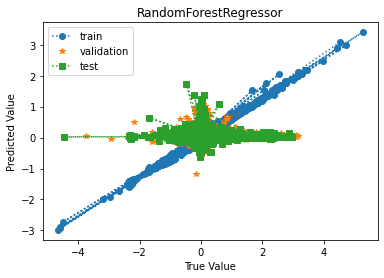

In [38]:
model_plot(model = "RandomForestRegressor", data = df_rf, n_est = tuned_model_rf.best_params_['n_estimators'])

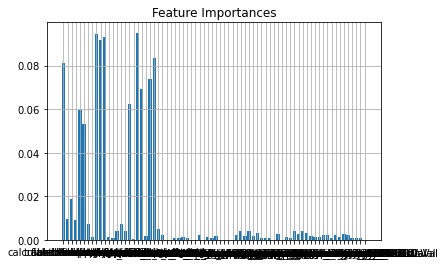

In [47]:
rf_feature_importance(n_est = tuned_model_rf.best_params_['n_estimators'])

In [25]:
%%time
df_boost = df.copy()
for i in [*[n for n in range(len(predictor(df_boost).columns)-4, 1, -4)], 1]:
    selector_boost = model_RFECV(model = 'Boosting', data = df_boost, min_features = i, n_est = 10)
    df_boost = df_boost[['logerror', *predictor(df_boost).columns[selector_boost.support_].tolist()]]
    print(selector_boost.n_features_, i)
    if selector_boost.n_features_ > i:
        break

74 70
Wall time: 1min 32s


In [26]:
%%time
tuned_model_boost = model_tuning(model = "Boosting",
                           data = df_boost,
                           parameters = {'n_estimators': [n for n in range(2, 100, 2)], 'base_estimator__max_leaf_nodes': [x for x in range(2, 100, 2)]})

Wall time: 2min 18s


In [27]:
print(tuned_model_boost.best_params_)

{'base_estimator__max_leaf_nodes': 86, 'n_estimators': 30}


In [28]:
%%time
print(model_mse(model = "Boosting",
                data = df_boost.copy(),
                n_est = tuned_model_boost.best_params_['n_estimators'],
                leaves = tuned_model_boost.best_params_['base_estimator__max_leaf_nodes']))

0.04567569606204479
Wall time: 30.5 s


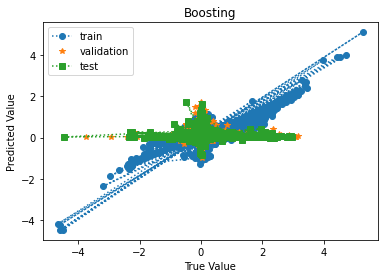

In [37]:
model_plot(model = "Boosting",
                data = df_boost.copy(),
                n_est = tuned_model_boost.best_params_['n_estimators'],
                leaves = tuned_model_boost.best_params_['base_estimator__max_leaf_nodes'])

In [31]:
%%time
df_lr = {}
selector_lr = {}
for d in [1, 2]:
    poly_lr = PolynomialFeatures(d, include_bias=False)
    df_lr[d] = np.array(df)
    poly_lr.fit(train(predictor(df_lr[d])))
    df_lr[d] = np.column_stack( (df_lr[d][:, 0], poly_lr.transform(predictor(df_lr[d])) ))
    for i in [*[n for n in range(predictor(df_lr[d]).shape[1]-4, 1, -4)], 1]:
        selector_lr[d] = model_RFECV(model = "LinearRegression", data = df_lr[d], min_features = i, d=d)
        df_lr[d] = df_lr[d][:, np.insert(selector_lr[d].support_, 0, True)]
        print(selector_lr[d].n_features_, i)
        if selector_lr[d].n_features_ > i:
            break;

70 70
68 66
2849 2845
Wall time: 5min 3s


In [32]:
df_lr[2].shape

(167888, 2850)

In [33]:
%%time
print(model_mse(model = "LinearRegression", data = df_lr[1]))
print(model_mse(model = "LinearRegression", data = df_lr[2]))

0.0336650821497555
0.2950100991616943
Wall time: 24.7 s


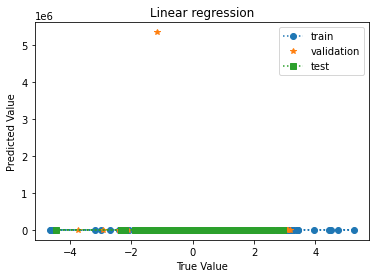

In [34]:
model_plot("LinearRegression", d=2)

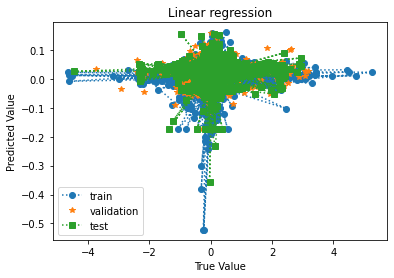

In [35]:
model_plot("LinearRegression", d=1)